In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch 
#from datasets import Dataset, DatasetDict, Image
from transformers import AutoImageProcessor, AutoModelForImageSegmentation, Trainer, TrainingArguments, AutoModelForSemanticSegmentation
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from PIL import Image
from skimage.color import label2rgb
import pytorch_lightning as pl
from skimage.io import*

2024-02-21 09:04:52.402964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 09:04:52.403116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 09:04:52.606747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
np.unique(imread('/kaggle/input/retina-blood-vessel/Data/train/mask/0.png'))
#need to convert to 0 and 1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [4]:
class RetinaDataset(Dataset):
    def __init__(self,root_dir,split,image_processor,train=True):
        self.root_dir = root_dir
        self.split = split
        self.image_processor = image_processor
        self.train = train
        
        split = 'train' if self.train else 'test'
        self.img_dir = os.path.join(self.root_dir,split,'image')
        self.label_dir = os.path.join(self.root_dir,split,'mask')
        
        img_files = []
        for root,dirs,files in os.walk(self.img_dir):
            img_files.extend(files)
        self.images = sorted(img_files)
        
        label_files = []
        for root,dirs ,files in os.walk(self.label_dir):
            label_files.extend(files)
        self.labels = sorted(label_files)
        
        assert len(self.images) == len(self.labels)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = Image.open(os.path.join(self.img_dir,self.images[idx]))
        masks = Image.open(os.path.join(self.label_dir,self.labels[idx]))
        
        binary_mask = np.array(masks)//255 # 0 and 1
        
        encoded_inputs = self.image_processor(image,binary_mask,return_tensors='pt')
        
        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() #remove batch
        return encoded_inputs

In [5]:
from transformers import SegformerImageProcessor
root_dir = '/kaggle/input/retina-blood-vessel/Data'
image_processor = SegformerImageProcessor(reduce_labels=False) #only two labels

train_ds = RetinaDataset(root_dir,'train',image_processor)
test_ds =  RetinaDataset(root_dir,'test',image_processor,train=False)

/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
print('Train_set',len(train_ds))
print('Test_set',len(test_ds))

Train_set 80
Test_set 20


In [7]:
encoded_inputs = train_ds[0]
encoded_inputs.keys()

dict_keys(['pixel_values', 'labels'])

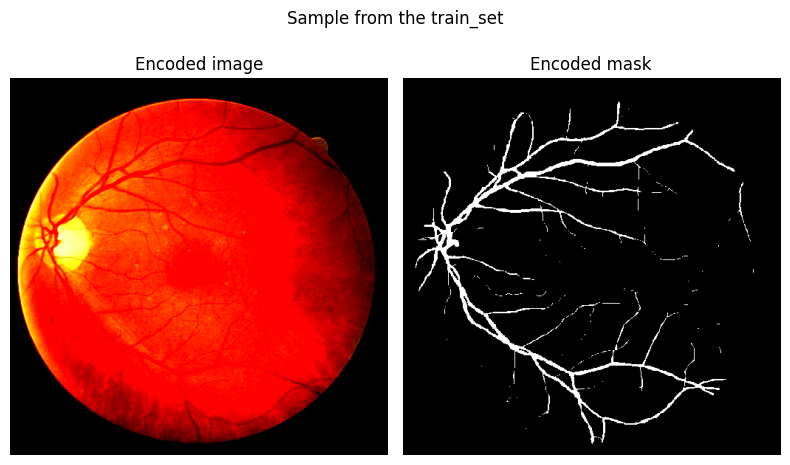

In [8]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(encoded_inputs['pixel_values'].permute(1,2,0))
ax[1].imshow(encoded_inputs['labels'],cmap='gray')
#ax[2].imshow(label2rgb(np.array(encoded_inputs['pixel_values'].permute(1,2,0)),np.array(encoded_inputs['labels']),bg_label=0,kind='overlay'))
ax[0].set_title('Encoded image')
ax[1].set_title('Encoded mask')
fig.suptitle('Sample from the train_set')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show();

In [9]:
train_loader = DataLoader(train_ds,batch_size=16,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=16,shuffle=False)

In [10]:
batch = next(iter(train_loader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([16, 3, 512, 512])
labels torch.Size([16, 512, 512])


In [11]:
id2label = {0:'bg',1:'retina'}
label2id = {v:k for k,v in id2label.items()}

print(label2id)

{'bg': 0, 'retina': 1}


In [12]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 873.7 kB/s eta 0:00:000:00:01


In [13]:
from transformers import SegformerForSemanticSegmentation
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import evaluate

In [14]:
metric = evaluate.load('mean_iou')

In [15]:
##training loop
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.wei

In [16]:
optimizer = optim.AdamW(model.parameters(),lr = 0.0006) # in the paper
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [17]:
model.train(); #set to training mode

In [18]:
#losses = []
#mean_iou = []
for epoch in range(100):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_loader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False)# we've already reduced the labels ourselves
          #losses.append(loss.item())
          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7581570744514465
Mean_iou: 0.2066638888152724
Mean accuracy: 0.5519359230398531
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40021181106567383
Mean_iou: 0.520534200061649
Mean accuracy: 0.5686426660021766
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2518264949321747
Mean_iou: 0.4948186113315945
Mean accuracy: 0.5222788572872974
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18544259667396545
Mean_iou: 0.6182234836298346
Mean accuracy: 0.6568315040733663
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1551479697227478
Mean_iou: 0.6242317405865474
Mean accuracy: 0.6552041765218977
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12977668642997742
Mean_iou: 0.6662668375385028
Mean accuracy: 0.7042684057654542
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10955489426851273
Mean_iou: 0.7094416452295624
Mean accuracy: 0.7649954864787027
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11330165714025497
Mean_iou: 0.6979243277848363
Mean accuracy: 0.7535581313081327
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10618739575147629
Mean_iou: 0.7092669534441421
Mean accuracy: 0.7615003851301105
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09550373256206512
Mean_iou: 0.7324576388286638
Mean accuracy: 0.8005196706351068
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09025592356920242
Mean_iou: 0.7287254958514875
Mean accuracy: 0.7980564021762021
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0897655338048935
Mean_iou: 0.7333863219148673
Mean accuracy: 0.797181090486158
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0917154923081398
Mean_iou: 0.7242555179563023
Mean accuracy: 0.7898961111431264
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08936716616153717
Mean_iou: 0.726375986091668
Mean accuracy: 0.7881271550798239
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08360159397125244
Mean_iou: 0.7467606921344013
Mean accuracy: 0.8216229055035293
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08252088725566864
Mean_iou: 0.7348671556784008
Mean accuracy: 0.7995828621466023
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09093088656663895
Mean_iou: 0.730721959858323
Mean accuracy: 0.8037936727295037
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08357638865709305
Mean_iou: 0.7481968619650838
Mean accuracy: 0.8175043192953805
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08187226951122284
Mean_iou: 0.7443441620688203
Mean accuracy: 0.8027713561198536
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07948992401361465
Mean_iou: 0.7502241183447086
Mean accuracy: 0.8125097545473012
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08067541569471359
Mean_iou: 0.7441319320495444
Mean accuracy: 0.803725358998048
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07239135354757309
Mean_iou: 0.7456673961228036
Mean accuracy: 0.795539946953489
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07777050137519836
Mean_iou: 0.7592746207510286
Mean accuracy: 0.8277279257325085
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07988923043012619
Mean_iou: 0.744362777780758
Mean accuracy: 0.805872869249904
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07555743306875229
Mean_iou: 0.7472657394486608
Mean accuracy: 0.8017708525833016
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07029908895492554
Mean_iou: 0.7657124529589815
Mean accuracy: 0.8352479468007576
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07513045519590378
Mean_iou: 0.7536178681158702
Mean accuracy: 0.8221509890594105
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07666465640068054
Mean_iou: 0.7474145891004451
Mean accuracy: 0.8080765027306152
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07395642250776291
Mean_iou: 0.7637305599722379
Mean accuracy: 0.8265965532713505
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07355226576328278
Mean_iou: 0.7568177196210546
Mean accuracy: 0.8145066325832151
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06911558657884598
Mean_iou: 0.7644561918559416
Mean accuracy: 0.8307356363249974
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07366133481264114
Mean_iou: 0.756756457049254
Mean accuracy: 0.8256777729054248
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06795112043619156
Mean_iou: 0.7639194849719622
Mean accuracy: 0.8251427902699897
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06836122274398804
Mean_iou: 0.7677227832440313
Mean accuracy: 0.8358887705092025
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07022347301244736
Mean_iou: 0.7679101677843514
Mean accuracy: 0.8484732321905647
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07132861763238907
Mean_iou: 0.7713434204763157
Mean accuracy: 0.8398926430340858
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06481672823429108
Mean_iou: 0.7647512059423469
Mean accuracy: 0.8193290839246782
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06878797709941864
Mean_iou: 0.7668703182197889
Mean accuracy: 0.8310695247217259
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06804385781288147
Mean_iou: 0.7789055753837465
Mean accuracy: 0.8432038281252487
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06809046119451523
Mean_iou: 0.7679076620759878
Mean accuracy: 0.8265385258678923
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06488840281963348
Mean_iou: 0.7611193105451004
Mean accuracy: 0.817512862167066
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.063886359333992
Mean_iou: 0.7712481519749872
Mean accuracy: 0.8406684676541132
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07420730590820312
Mean_iou: 0.7597471515264494
Mean accuracy: 0.8288095296585236
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07185707986354828
Mean_iou: 0.7567107836294392
Mean accuracy: 0.8215787614558918
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06697554886341095
Mean_iou: 0.772810317653994
Mean accuracy: 0.8496537001260152
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06428578495979309
Mean_iou: 0.7706087672012192
Mean accuracy: 0.8290846889402133
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06710884720087051
Mean_iou: 0.774596760304547
Mean accuracy: 0.8417368751262194
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06461949646472931
Mean_iou: 0.7849182995506799
Mean accuracy: 0.8603618974813583
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06909841299057007
Mean_iou: 0.7598946485788879
Mean accuracy: 0.8191558988395324
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06747499108314514
Mean_iou: 0.7597426221978212
Mean accuracy: 0.8140315367487798
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06634558737277985
Mean_iou: 0.7740144188231379
Mean accuracy: 0.8383595947361948
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06282050907611847
Mean_iou: 0.7802149993305137
Mean accuracy: 0.8399344746716255
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06648653745651245
Mean_iou: 0.7692309627022744
Mean accuracy: 0.8294977983518488
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06116668879985809
Mean_iou: 0.7840504039719246
Mean accuracy: 0.8635133857518411
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06677213311195374
Mean_iou: 0.7790983440015544
Mean accuracy: 0.8403167551800144
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06928138434886932
Mean_iou: 0.7728482456977273
Mean accuracy: 0.8380623418901396
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06851280480623245
Mean_iou: 0.7675113454651612
Mean accuracy: 0.8237086522833628
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06909648329019547
Mean_iou: 0.751628230722015
Mean accuracy: 0.7960275186571408
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.069952093064785
Mean_iou: 0.7623528623469675
Mean accuracy: 0.8183363363946219
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0685393437743187
Mean_iou: 0.7685131546116841
Mean accuracy: 0.8287295862786124
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06425809860229492
Mean_iou: 0.7775700782564772
Mean accuracy: 0.833936832858484
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06591823697090149
Mean_iou: 0.7739811406790078
Mean accuracy: 0.8411077821005806
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06424706429243088
Mean_iou: 0.7784107563118814
Mean accuracy: 0.835863431226742
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.068880096077919
Mean_iou: 0.7669934638836946
Mean accuracy: 0.82244244049742
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0646030381321907
Mean_iou: 0.7757488099449136
Mean accuracy: 0.8241180458938797
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06164665147662163
Mean_iou: 0.7891708260365374
Mean accuracy: 0.8453150656197774
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06022000312805176
Mean_iou: 0.7858482672497235
Mean accuracy: 0.8456176758630087
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.060229137539863586
Mean_iou: 0.7897664183362151
Mean accuracy: 0.8517753641725487
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06231218948960304
Mean_iou: 0.7837800091211905
Mean accuracy: 0.8475867907644727
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06150520592927933
Mean_iou: 0.7797725202478797
Mean accuracy: 0.8446733806555894
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06201533228158951
Mean_iou: 0.7875592946713816
Mean accuracy: 0.8581590021303239
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06273208558559418
Mean_iou: 0.7820685959589381
Mean accuracy: 0.8535912187030279
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06481374800205231
Mean_iou: 0.7762922824549898
Mean accuracy: 0.8330277960512853
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06552357971668243
Mean_iou: 0.7659198560976619
Mean accuracy: 0.8290762815051482
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06493190675973892
Mean_iou: 0.781417863452808
Mean accuracy: 0.8514305900093019
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06219647824764252
Mean_iou: 0.7801409350488815
Mean accuracy: 0.844650246818458
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.063779316842556
Mean_iou: 0.7744625076049658
Mean accuracy: 0.8368553934147037
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06355477124452591
Mean_iou: 0.7829397330726982
Mean accuracy: 0.8492408774613265
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05911160260438919
Mean_iou: 0.788880452176023
Mean accuracy: 0.8534914783362504
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06492572277784348
Mean_iou: 0.7767782392469016
Mean accuracy: 0.8388897641432027
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06365692615509033
Mean_iou: 0.7836113404265939
Mean accuracy: 0.8544392061943497
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05580538511276245
Mean_iou: 0.8029492302120673
Mean accuracy: 0.8764525366034943
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06568634510040283
Mean_iou: 0.7811627992637953
Mean accuracy: 0.8469661135072148
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.061392106115818024
Mean_iou: 0.7783970628112225
Mean accuracy: 0.8341053197441879
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05794689431786537
Mean_iou: 0.7964855409714631
Mean accuracy: 0.8572872890226542
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.060419000685214996
Mean_iou: 0.7894224964142736
Mean accuracy: 0.8549445577996899
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.055653687566518784
Mean_iou: 0.7969916596479829
Mean accuracy: 0.8594396968722359
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06428604573011398
Mean_iou: 0.7776585972345604
Mean accuracy: 0.8395651223869497
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06026655435562134
Mean_iou: 0.7871419865078229
Mean accuracy: 0.8407901615966719
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.059398353099823
Mean_iou: 0.7853206220899192
Mean accuracy: 0.8459543505661343
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.057855237275362015
Mean_iou: 0.7996149572150901
Mean accuracy: 0.8655058377368443
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05644908547401428
Mean_iou: 0.8038334948236707
Mean accuracy: 0.8733264399679982
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06399115175008774
Mean_iou: 0.7986949446346767
Mean accuracy: 0.8717589783116892
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0577324703335762
Mean_iou: 0.788855833149422
Mean accuracy: 0.8504192309182641
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.058518312871456146
Mean_iou: 0.7939195111973285
Mean accuracy: 0.8586479476578142
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.060456886887550354
Mean_iou: 0.7914834880200049
Mean accuracy: 0.8598830275986244
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05739091709256172
Mean_iou: 0.7922186648305022
Mean accuracy: 0.8536362471017216
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.054502300918102264
Mean_iou: 0.8046222327886932
Mean accuracy: 0.8681216424285063
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.056610893458127975
Mean_iou: 0.7898259828387568
Mean accuracy: 0.8671740653407649
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06229235976934433
Mean_iou: 0.7883329119463116
Mean accuracy: 0.8580732805867526


In [19]:
model.save_pretrained('/kaggle/working/')

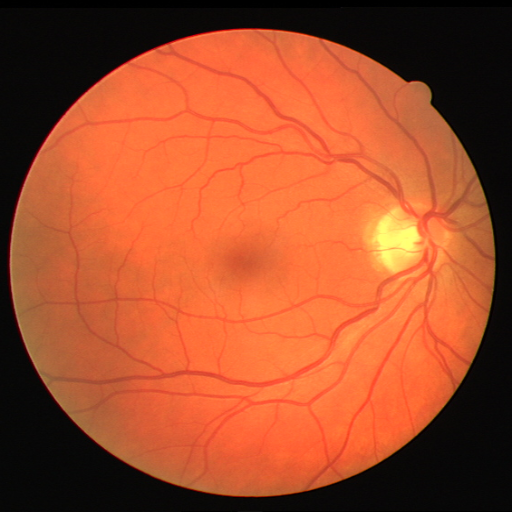

In [20]:
sample_img = Image.open('/kaggle/input/retina-blood-vessel/Data/test/image/1.png')
sample_img

In [25]:
pixel_values = image_processor(sample_img, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [26]:
with torch.no_grad():
    outp = model(pixel_values=pixel_values)

In [27]:
logits = outp.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [29]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outp, target_sizes=[sample_img.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [30]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

Text(0.5, 1.0, 'Example inference-Sample input with predicted mask')

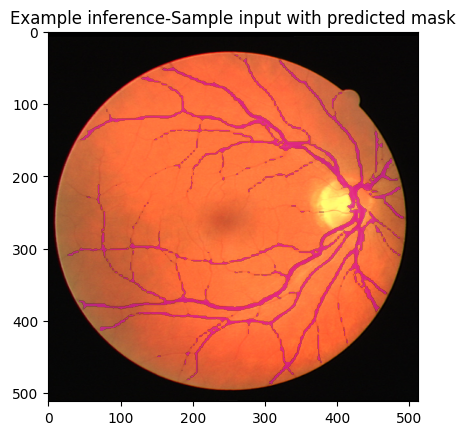

In [37]:
plt.imshow(sample_img)
show_mask(predicted_segmentation_map,plt.gca(),random_color=True)
plt.title('Example inference-Sample input with predicted mask')

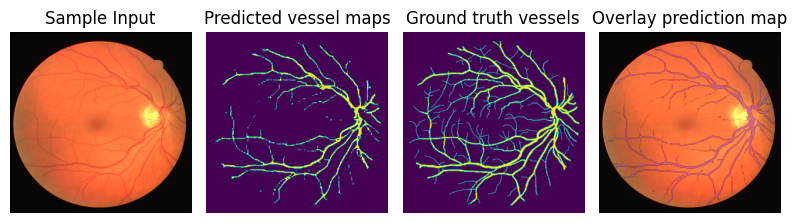

In [51]:
fig,ax = plt.subplots(1,4,figsize=(8,5),sharex=True)
ax[0].imshow(sample_img)
ax[1].imshow(predicted_segmentation_map)
ax[2].imshow(Image.open('/kaggle/input/retina-blood-vessel/Data/test/mask/1.png'))
ax[0].set_title('Sample Input')
ax[1].set_title('Predicted vessel maps')
ax[2].set_title('Ground truth vessels')
ax[3].imshow(sample_img)
show_mask(predicted_segmentation_map,ax[3],random_color=True)
ax[3].set_title('Overlay prediction map')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show();


In [53]:
gt = Image.open('/kaggle/input/retina-blood-vessel/Data/test/mask/1.png')
gt = np.array(gt)
print(gt.shape)

(512, 512)


In [54]:
inf_metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[gt],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [55]:
inf_metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [56]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.7883329119463116
mean_accuracy 0.8580732805867526
overall_accuracy 0.9741859436035156
---------------------
per-category metrics:


,IoU,accuracy
bg,0.973130,0.988240
retina,0.603536,0.727906
